In [1]:
from pprint import pformat

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

sns.set()

## `[2023-02-27]` Follow-up experiment by adding the `ConsensusPathDB` network in addition to the `HumanNet`


For `ConsensusPathDB`, it is no longer the case that the most well recovered disease annotations are from text-mining. Instead, `n2v-logreg` and `labelprop` achieves the best performance in terms of capturing `curated` and `knolwedge` annotations, respectively. This is in concordance with the hypothesis that the `HumanNet` resulted in best `text-mined` disaese annotation reocovery due to its construction, which contains many text-mined `co-citation` gene interaction information.

To further validate the hypothesis, we can perofrm a *leave-one-channel-out* experiment on `HumanNet`, where we remove an edge if that edges come solely from this particular channel.

In [2]:
df = pd.read_csv("aggregated_results/main_results_2023-02-27.csv")
# df

In [3]:
# Take the mean score for each task across all runs
reduced_df = (
    df
    .groupby(["task_name", "network", "label", "method"], as_index=False)
    .mean()
    .drop(columns=["runid"])
)
# reduced_df

In [4]:
label_order = df.groupby("label")["test_log2pr"].median().sort_values(ascending=False).index.tolist()
print(f"Gene set collections sorted by mean performance across all methods:\n{pformat(label_order)}")

Gene set collections sorted by mean performance across all methods:
['diseases',
 'diseases_textminingfiltered',
 'diseases_knowledgefiltered',
 'disgenet_curated',
 'disgenet',
 'hpo',
 'disgenet_befree',
 'disgenet_animal',
 'diseases_experimentsfiltered',
 'disgenet_gwas']


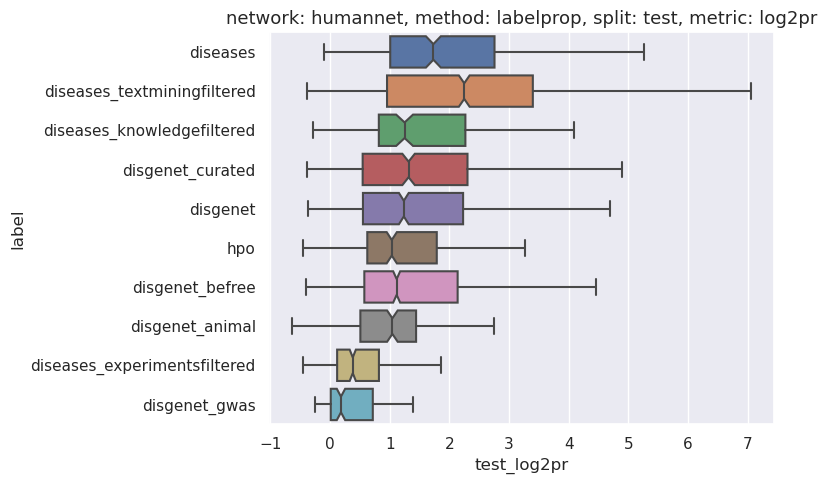

In [5]:
# -------------------
selected_network = "humannet"
selected_method = "labelprop"
selected_split = "test"
selected_metric = "log2pr"
# -------------------

plt.figure(figsize=(8, 5))

sns.boxplot(
    data=df.query("network == @selected_network & method == @selected_method"),
    x=f"{selected_split}_{selected_metric}",
    y="label",
    showfliers=False,
    notch=True,
    order=label_order,
)

plt.title(
    f"network: {selected_network}, "
    f"method: {selected_method}, "
    f"split: {selected_split}, "
    f"metric: {selected_metric}",
    fontsize=13,
)

plt.tight_layout()
plt.show()

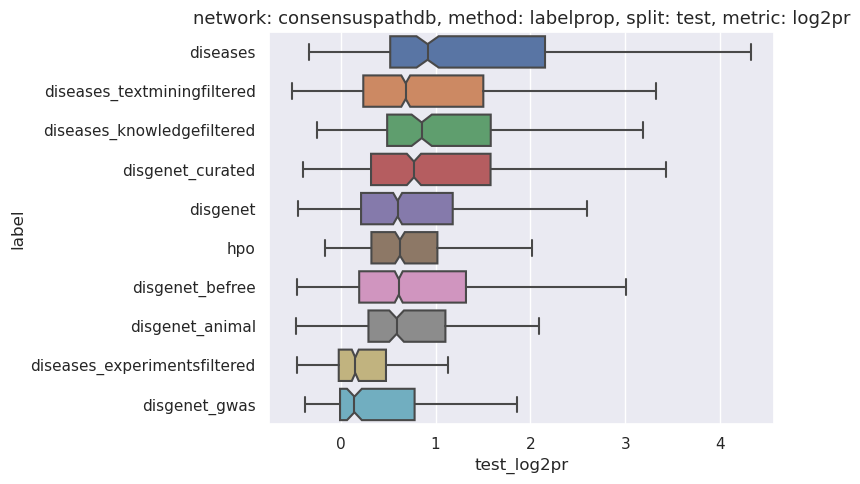

In [6]:
# -------------------
selected_network = "consensuspathdb"
selected_method = "labelprop"
selected_split = "test"
selected_metric = "log2pr"
# -------------------

plt.figure(figsize=(8, 5))

sns.boxplot(
    data=df.query("network == @selected_network & method == @selected_method"),
    x=f"{selected_split}_{selected_metric}",
    y="label",
    showfliers=False,
    notch=True,
    order=label_order,
)

plt.title(
    f"network: {selected_network}, "
    f"method: {selected_method}, "
    f"split: {selected_split}, "
    f"metric: {selected_metric}",
    fontsize=13,
)

plt.tight_layout()
plt.show()

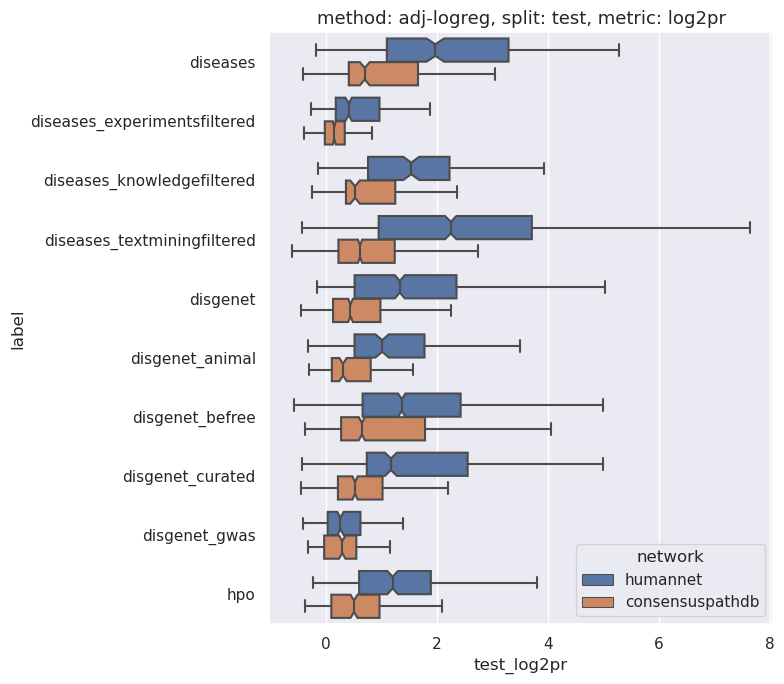

In [7]:
# -------------------
selected_method = "adj-logreg"
selected_split = "test"
selected_metric = "log2pr"
# -------------------

plt.figure(figsize=(8, 7))

sns.boxplot(
    data=df.query("method == @selected_method"),
    x=f"{selected_split}_{selected_metric}",
    y="label",
    showfliers=False,
    notch=True,
    hue="network",
    hue_order=["humannet", "consensuspathdb"],
    order=sorted(label_order),
)

plt.title(
    f"method: {selected_method}, "
    f"split: {selected_split}, "
    f"metric: {selected_metric}",
    fontsize=13,
)

plt.tight_layout()
plt.show()

In [8]:
# Take the average score across all tasks within a run
summary_df = df.groupby(["network", "label", "method", "runid"], as_index=False).mean(numeric_only=True)
summary_df

,network,label,method,runid,train_log2pr,val_log2pr,test_log2pr,train_auroc,val_auroc,test_auroc
0,consensuspathdb,diseases,adj-logreg,0.0,4.716554,1.270200,1.118423,0.999514,0.603954,0.556196
1,consensuspathdb,diseases,adj-logreg,1.0,4.716554,1.270200,1.118423,0.999514,0.603954,0.556196
2,consensuspathdb,diseases,adj-logreg,2.0,4.716554,1.270200,1.118423,0.999514,0.603954,0.556196
3,consensuspathdb,diseases,adj-logreg,3.0,4.716554,1.270200,1.118423,0.999514,0.603954,0.556196
4,consensuspathdb,diseases,adj-logreg,4.0,4.716554,1.270200,1.118423,0.999514,0.603954,0.556196
...,...,...,...,...,...,...,...,...,...,...
495,humannet,hpo,n2v-logreg,0.0,2.714869,1.157363,0.984543,0.849228,0.624539,0.603429
496,humannet,hpo,n2v-logreg,1.0,2.703960,1.179421,0.991783,0.848537,0.623688,0.606434
497,humannet,hpo,n2v-logreg,2.0,2.701912,1.200389,0.987771,0.849130,0.633192,0.609314
498,humannet,hpo,n2v-logreg,3.0,2.698038,1.255955,0.948794,0.846991,0.631252,0.600933


In [9]:
def mean_std_str(x, *, k=3):
    mean = np.mean(x)
    std = np.std(x)
    return f"{mean:.{k}f} ± {std:.{k}f}"

In [10]:
_ = [print(f"{i!r},") for i in sorted(summary_df["label"].unique())]

'diseases',
'diseases_experimentsfiltered',
'diseases_knowledgefiltered',
'diseases_textminingfiltered',
'disgenet',
'disgenet_animal',
'disgenet_befree',
'disgenet_curated',
'disgenet_gwas',
'hpo',


In [11]:
selected_labels = [
#     'diseases',
    'diseases_experimentsfiltered',
    'diseases_knowledgefiltered',
    'diseases_textminingfiltered',
#     'disgenet',
    'disgenet_animal',
    'disgenet_befree',
    'disgenet_curated',
    'disgenet_gwas',
    'hpo',
]

In [12]:
(
    summary_df.query("network == 'humannet'")
    .pivot_table("test_log2pr", "label", "method", aggfunc=mean_std_str)
    .loc[selected_labels]
    .style
    .highlight_max(color="lightgreen", axis=1)
    .highlight_max(color="lightblue", axis=0)
)

method,adj-logreg,gcn,graphsage,labelprop,n2v-logreg
label,,,,,
diseases_experimentsfiltered,0.658 ± 0.000,0.556 ± 0.143,0.437 ± 0.067,0.556 ± 0.000,0.401 ± 0.055
diseases_knowledgefiltered,1.752 ± 0.000,1.622 ± 0.022,1.537 ± 0.037,1.590 ± 0.000,1.417 ± 0.037
diseases_textminingfiltered,2.387 ± 0.000,1.893 ± 0.053,2.086 ± 0.035,2.333 ± 0.000,1.850 ± 0.012
disgenet_animal,1.161 ± 0.000,1.007 ± 0.032,1.078 ± 0.067,1.079 ± 0.000,0.875 ± 0.030
disgenet_befree,1.683 ± 0.000,0.912 ± 0.060,1.113 ± 0.024,1.465 ± 0.000,1.089 ± 0.015
disgenet_curated,1.708 ± 0.000,1.631 ± 0.038,1.620 ± 0.064,1.577 ± 0.000,1.518 ± 0.037
disgenet_gwas,0.483 ± 0.000,0.411 ± 0.012,0.413 ± 0.042,0.424 ± 0.000,0.394 ± 0.048
hpo,1.321 ± 0.000,1.073 ± 0.032,1.083 ± 0.055,1.286 ± 0.000,0.978 ± 0.015


In [13]:
(
    summary_df.query("network == 'consensuspathdb'")
    .pivot_table("test_log2pr", "label", "method", aggfunc=mean_std_str, fill_value="-")
    .loc[selected_labels]
    .style
    .highlight_max(color="lightgreen", axis=1)
    .highlight_max(color="lightblue", axis=0)
)

method,adj-logreg,gcn,graphsage,labelprop,n2v-logreg
label,,,,,
diseases_experimentsfiltered,0.274 ± 0.000,0.307 ± 0.027,0.248 ± 0.036,0.305 ± 0.000,0.253 ± 0.018
diseases_knowledgefiltered,0.876 ± 0.000,0.996 ± 0.068,0.954 ± 0.048,1.086 ± 0.000,0.999 ± 0.037
diseases_textminingfiltered,0.952 ± 0.000,1.160 ± 0.036,1.187 ± 0.023,1.076 ± 0.000,0.777 ± 0.027
disgenet_animal,0.497 ± 0.000,0.731 ± 0.060,0.740 ± 0.066,0.742 ± 0.000,0.635 ± 0.063
disgenet_befree,1.119 ± 0.000,0.699 ± 0.068,0.841 ± 0.069,0.948 ± 0.000,0.490 ± 0.023
disgenet_curated,0.720 ± 0.000,0.890 ± 0.047,0.993 ± 0.053,1.101 ± 0.000,0.781 ± 0.031
disgenet_gwas,0.398 ± 0.000,0.321 ± 0.045,0.278 ± 0.032,0.370 ± 0.000,0.246 ± 0.040
hpo,0.572 ± 0.000,0.699 ± 0.078,0.615 ± 0.058,0.821 ± 0.000,0.557 ± 0.016


In [14]:
(
    summary_df.query("network == 'humannet'")
    .pivot_table("test_log2pr", "label", "method", aggfunc="mean")
    .style
    .background_gradient(cmap="viridis", axis=0)
)

method,adj-logreg,gcn,graphsage,labelprop,n2v-logreg
label,,,,,
diseases,2.153582,1.773738,1.843203,2.012275,1.780809
diseases_experimentsfiltered,0.657608,0.555683,0.436629,0.556172,0.400685
diseases_knowledgefiltered,1.751976,1.622343,1.536537,1.589788,1.416606
diseases_textminingfiltered,2.386551,1.892860,2.085795,2.333133,1.850053
disgenet,1.611405,1.392709,1.490266,1.530468,1.349018
disgenet_animal,1.160959,1.006777,1.078450,1.079345,0.875081
disgenet_befree,1.683212,0.912123,1.113258,1.464942,1.089172
disgenet_curated,1.707756,1.630899,1.620016,1.576799,1.518366
disgenet_gwas,0.483236,0.411234,0.413168,0.424201,0.393942


In [15]:
(
    summary_df.query("network == 'consensuspathdb'")
    .pivot_table("test_log2pr", "label", "method", aggfunc="mean")
    .style
    .background_gradient(cmap="viridis", axis=0)
)

method,adj-logreg,gcn,graphsage,labelprop,n2v-logreg
label,,,,,
diseases,1.118423,1.192129,1.256295,1.315239,1.012072
diseases_experimentsfiltered,0.273697,0.307351,0.248200,0.305149,0.253006
diseases_knowledgefiltered,0.875624,0.995725,0.954145,1.086212,0.999008
diseases_textminingfiltered,0.951753,1.159991,1.186707,1.075918,0.777173
disgenet,0.693120,0.842527,0.855409,0.895811,0.724564
disgenet_animal,0.496692,0.730733,0.740338,0.742446,0.635058
disgenet_befree,1.118844,0.698850,0.840728,0.947988,0.490229
disgenet_curated,0.720370,0.890126,0.992528,1.100587,0.781012
disgenet_gwas,0.398208,0.320639,0.278400,0.369930,0.246401


## `[2023-02-16]` Experiment with `HumanNet` network to predict different disease annotations using various network-based ML methods

All methods show that `text-mined` disease annotations are among the easiest to recover. This is potentially due to that a large portions of gene interaction evidences in `HumanNet` came from literature text-mined evidences (more specifically, co-citation evidences).

In the next experiment, we will add the `ConsensusPathDB` network, which does not explicitly contain text-mined gene interaction information (although it is expected that curated knowledge would correlate with co-citation to some extend). If `text-mined` annotations are no longer consistently the easiest to predict, then it indicates that the `HumanNet` co-citation channels contributed a large portion to the good predictions of `text-mined` annotations. In turn, it suggests that *current network-based ML methods rely on the **homophily** (or similarly, the **Guild-by-Assoction**) assumption*, and thus might fail to identify disease genes that have higher order interactions, which do not necessarily localize in the netowrk.

- [ ] Is there any such example of disease gene set, where the disease genes are scattered all over the network, and yet have some underlying regularity that they follow in the network?

In [16]:
df = pd.read_csv("aggregated_results/main_results_2023-02-16.csv")
# df

In [17]:
# Take the mean score for each task across all runs
reduced_df = (
    df
    .groupby(["task_name", "network", "label", "method"], as_index=False)
    .mean()
    .drop(columns=["runid"])
)
# reduced_df

In [18]:
label_order = df.groupby("label")["test_log2pr"].median().sort_values(ascending=False).index.tolist()
print(f"Gene set collections sorted by mean performance across all methods:\n{pformat(label_order)}")

Gene set collections sorted by mean performance across all methods:
['diseases_textminingfiltered',
 'diseases',
 'diseases_knowledgefiltered',
 'disgenet_curated',
 'disgenet',
 'disgenet_befree',
 'hpo',
 'disgenet_animal',
 'diseases_experimentsfiltered',
 'disgenet_gwas']


In [19]:
method_order = df.groupby("method")["test_log2pr"].median().sort_values(ascending=False).index.tolist()
print(f"Methods sorted by mean performance across all gene set collections:\n{pformat(method_order)}")

Methods sorted by mean performance across all gene set collections:
['adj-logreg',
 'labelprop',
 'adj-svm',
 'graphsage',
 'gcn',
 'n2v-logreg',
 'n2v-svm',
 'gin',
 'gat']


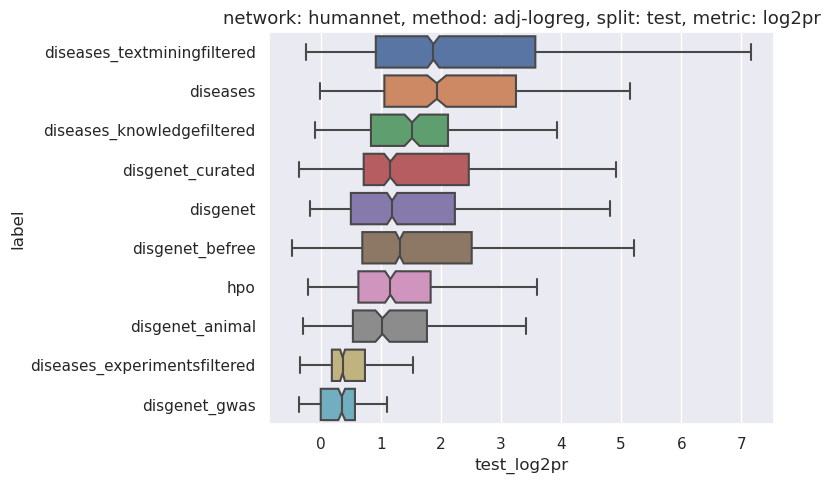

In [20]:
# -------------------
selected_network = "humannet"
selected_method = "adj-logreg"
selected_split = "test"
selected_metric = "log2pr"
# -------------------

plt.figure(figsize=(8, 5))

sns.boxplot(
    data=df.query("network == @selected_network & method == @selected_method"),
    x=f"{selected_split}_{selected_metric}",
    y="label",
    showfliers=False,
    notch=True,
    order=label_order,
)

plt.title(
    f"network: {selected_network}, "
    f"method: {selected_method}, "
    f"split: {selected_split}, "
    f"metric: {selected_metric}",
    fontsize=13,
)

plt.tight_layout()
plt.show()

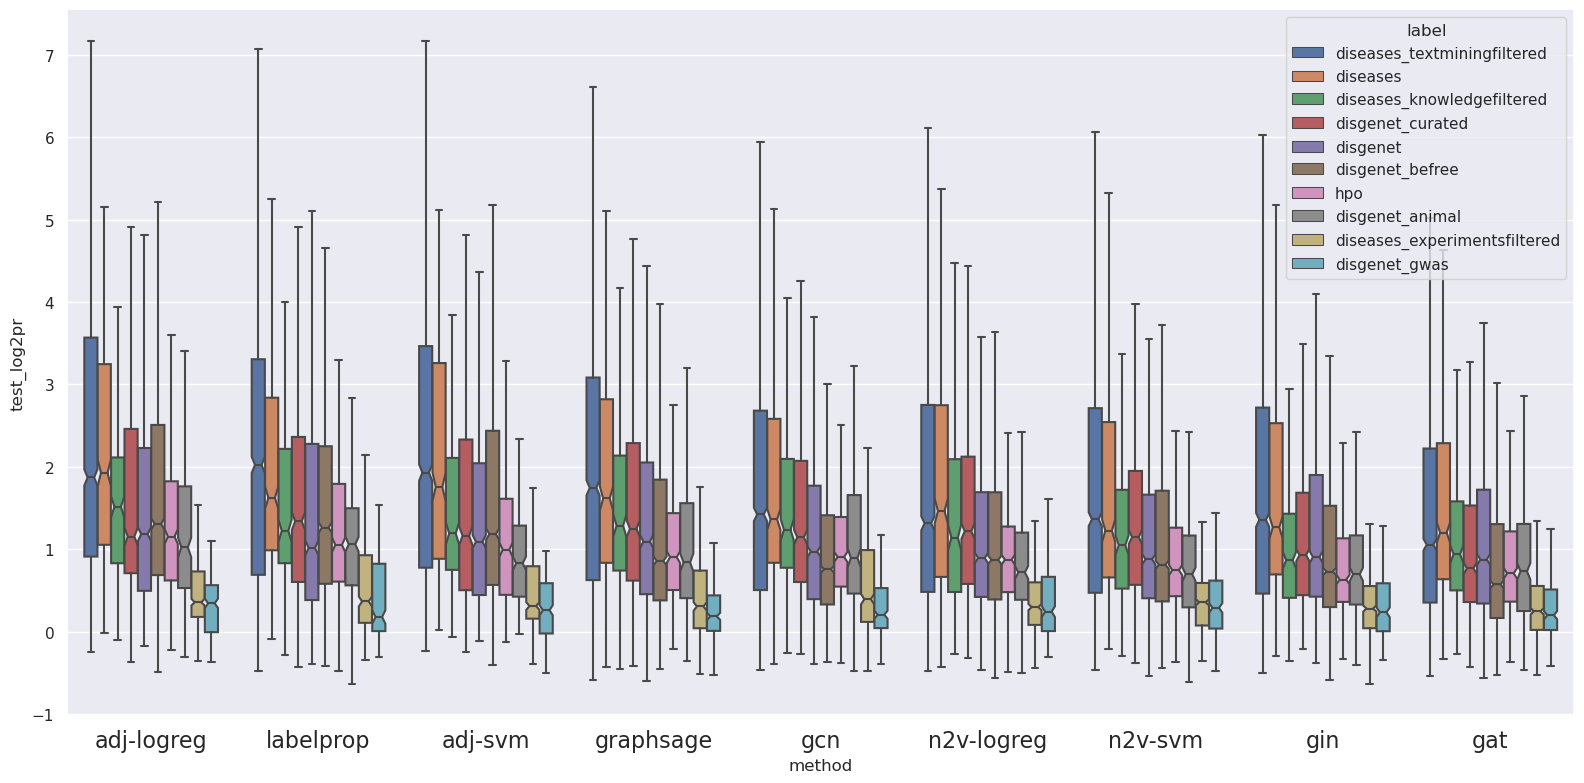

In [21]:
plt.figure(figsize=(16, 8))

sns.boxplot(
    data=df.query("network == 'humannet'"),
    hue="label",
    y="test_log2pr",
    x="method",
    showfliers=False,
    notch=True,
    hue_order=label_order,
    order=method_order,
)

plt.xticks(fontsize=16)

plt.tight_layout()
plt.show()

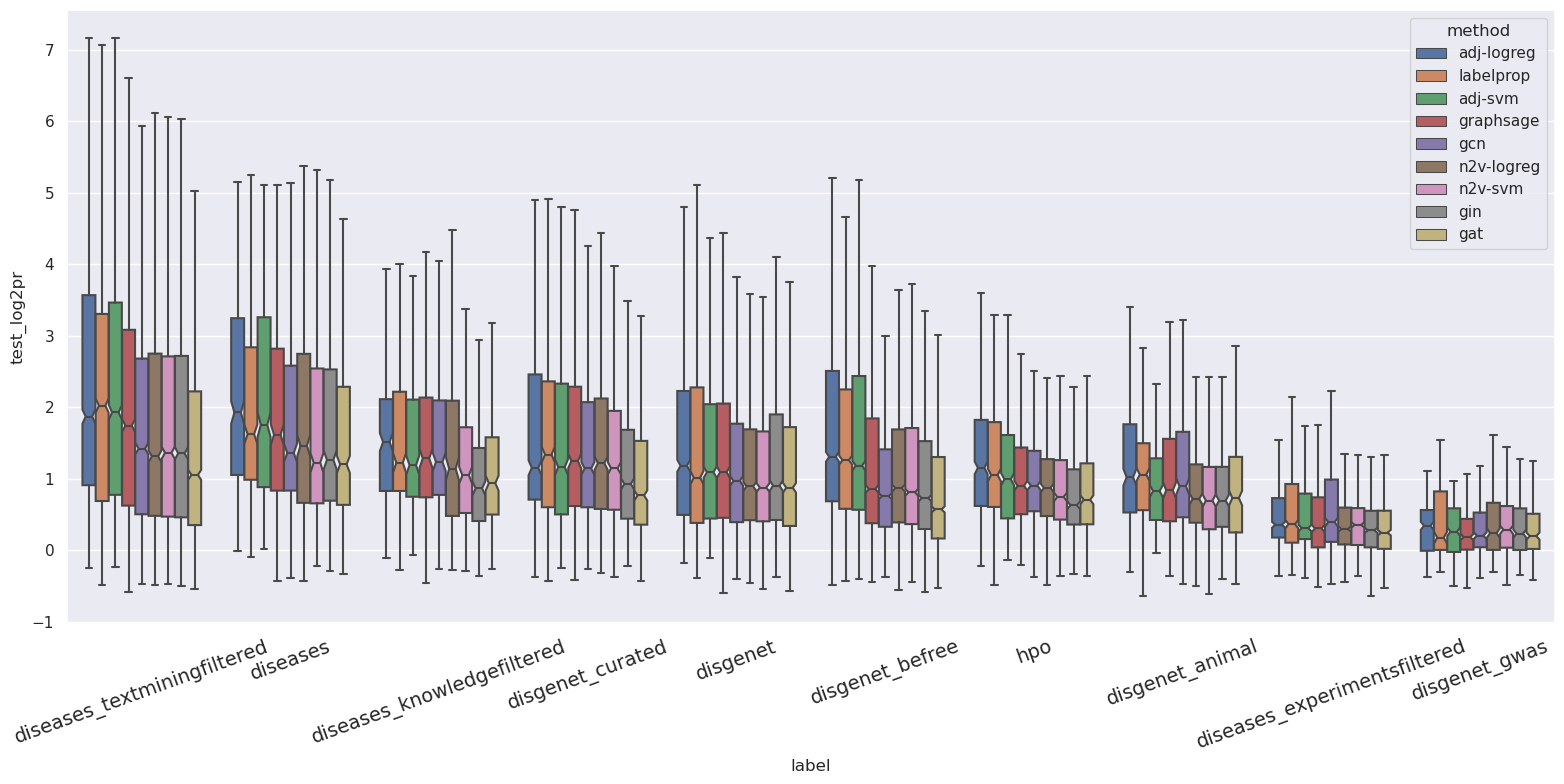

In [22]:
plt.figure(figsize=(16, 8))

sns.boxplot(
    data=df.query("network == 'humannet'"),
    x="label",
    y="test_log2pr",
    hue="method",
    showfliers=False,
    notch=True,
    hue_order=method_order,
    order=label_order,
)
plt.xticks(fontsize=14, rotation=20)

plt.tight_layout()
plt.show()

In [23]:
# Take the average score across all tasks within a run
summary_df = df.groupby(["network", "label", "method", "runid"], as_index=False).mean(numeric_only=True)
summary_df

,network,label,method,runid,train_log2pr,val_log2pr,test_log2pr,train_auroc,val_auroc,test_auroc
0,humannet,diseases,adj-logreg,0.0,4.752281,2.470688,2.148892,1.000000,0.708776,0.669319
1,humannet,diseases,adj-logreg,1.0,4.752281,2.470688,2.148892,1.000000,0.708776,0.669319
2,humannet,diseases,adj-logreg,2.0,4.752281,2.470688,2.148892,1.000000,0.708776,0.669319
3,humannet,diseases,adj-logreg,3.0,4.752281,2.470688,2.148892,1.000000,0.708776,0.669319
4,humannet,diseases,adj-logreg,4.0,4.752281,2.470688,2.148892,1.000000,0.708776,0.669319
...,...,...,...,...,...,...,...,...,...,...
445,humannet,hpo,n2v-svm,0.0,2.781610,1.058070,0.944477,0.852157,0.611532,0.598107
446,humannet,hpo,n2v-svm,1.0,2.801681,1.061805,0.891099,0.852754,0.618118,0.582716
447,humannet,hpo,n2v-svm,2.0,2.788817,1.053075,0.986579,0.850379,0.618501,0.602486
448,humannet,hpo,n2v-svm,3.0,2.787287,1.081995,0.920967,0.852656,0.611687,0.596427


In [24]:
def mean_std_str(x, *, k=3):
    mean = np.mean(x)
    std = np.std(x)
    return f"{mean:.{k}f} ± {std:.{k}f}"

selected_methods = [
    "adj-logreg",
    "adj-svm",
    "n2v-logreg",
    "n2v-svm",
    "gat",
    "gcn",
    "gin",
    "graphsage",
    "labelprop",
]

In [25]:
(
    summary_df
    .pivot_table("test_log2pr", "label", "method", aggfunc=mean_std_str)[selected_methods]
    .style
    .highlight_max(color="lightgreen", axis=1)
    .highlight_max(color="lightblue", axis=0)
)

method,adj-logreg,adj-svm,n2v-logreg,n2v-svm,gat,gcn,gin,graphsage,labelprop
label,,,,,,,,,
diseases,2.149 ± 0.000,2.053 ± 0.000,1.782 ± 0.021,1.637 ± 0.069,1.535 ± 0.066,1.767 ± 0.064,1.630 ± 0.044,1.865 ± 0.026,2.000 ± 0.000
diseases_experimentsfiltered,0.608 ± 0.000,0.550 ± 0.000,0.413 ± 0.036,0.420 ± 0.031,0.409 ± 0.022,0.649 ± 0.061,0.419 ± 0.042,0.478 ± 0.045,0.592 ± 0.000
diseases_knowledgefiltered,1.737 ± 0.000,1.627 ± 0.000,1.452 ± 0.065,1.322 ± 0.044,1.275 ± 0.063,1.597 ± 0.063,1.143 ± 0.128,1.551 ± 0.042,1.581 ± 0.000
diseases_textminingfiltered,2.262 ± 0.000,2.231 ± 0.000,1.751 ± 0.016,1.751 ± 0.011,1.444 ± 0.069,1.755 ± 0.033,1.759 ± 0.046,1.996 ± 0.038,2.156 ± 0.000
disgenet,1.562 ± 0.000,1.479 ± 0.000,1.243 ± 0.022,1.229 ± 0.048,1.184 ± 0.043,1.286 ± 0.034,1.326 ± 0.050,1.420 ± 0.023,1.441 ± 0.000
disgenet_animal,1.141 ± 0.000,1.038 ± 0.000,0.917 ± 0.032,0.815 ± 0.017,0.911 ± 0.053,1.071 ± 0.061,0.843 ± 0.021,1.033 ± 0.042,1.100 ± 0.000
disgenet_befree,1.681 ± 0.000,1.559 ± 0.000,1.175 ± 0.052,1.152 ± 0.021,0.885 ± 0.088,1.025 ± 0.053,1.057 ± 0.098,1.238 ± 0.069,1.542 ± 0.000
disgenet_curated,1.682 ± 0.000,1.615 ± 0.000,1.517 ± 0.046,1.422 ± 0.026,1.091 ± 0.049,1.534 ± 0.058,1.235 ± 0.065,1.573 ± 0.051,1.582 ± 0.000
disgenet_gwas,0.556 ± 0.000,0.491 ± 0.000,0.380 ± 0.025,0.379 ± 0.029,0.363 ± 0.024,0.436 ± 0.032,0.461 ± 0.071,0.442 ± 0.026,0.487 ± 0.000


In [26]:
(
    summary_df
    .pivot_table("test_log2pr", "label", "method", aggfunc="mean")[selected_methods]
    .style
    .background_gradient(cmap="viridis", axis=1)
)

method,adj-logreg,adj-svm,n2v-logreg,n2v-svm,gat,gcn,gin,graphsage,labelprop
label,,,,,,,,,
diseases,2.148892,2.052846,1.781533,1.637239,1.535317,1.766804,1.630367,1.864945,2.000371
diseases_experimentsfiltered,0.607535,0.550002,0.412603,0.420003,0.408897,0.648558,0.418930,0.478154,0.592420
diseases_knowledgefiltered,1.736521,1.627125,1.452297,1.321943,1.274713,1.596721,1.143359,1.550980,1.581053
diseases_textminingfiltered,2.261506,2.231498,1.751411,1.751305,1.444382,1.754844,1.759175,1.995852,2.156249
disgenet,1.561691,1.478798,1.243038,1.229166,1.183720,1.285928,1.326207,1.419996,1.440647
disgenet_animal,1.141314,1.037989,0.916612,0.814750,0.910776,1.071028,0.843157,1.033257,1.099949
disgenet_befree,1.681334,1.558626,1.175086,1.151716,0.884782,1.024702,1.056520,1.238039,1.541587
disgenet_curated,1.682385,1.614927,1.516737,1.421555,1.091096,1.533926,1.234930,1.573371,1.582242
disgenet_gwas,0.556153,0.490572,0.379747,0.379197,0.363260,0.435591,0.461447,0.442420,0.486612


Notes
- In contrast to the main results shown in the ``nlevel`` v1 manuscript, ``GAT`` performs poorly, which might because it is hard to tune and thus rquires some efforts to tune it to the optimal performance.

In [27]:
(
    summary_df
    .pivot_table("test_log2pr", "label", "method", aggfunc="mean")[selected_methods]
    .style
    .background_gradient(cmap="viridis", axis=0)
)

method,adj-logreg,adj-svm,n2v-logreg,n2v-svm,gat,gcn,gin,graphsage,labelprop
label,,,,,,,,,
diseases,2.148892,2.052846,1.781533,1.637239,1.535317,1.766804,1.630367,1.864945,2.000371
diseases_experimentsfiltered,0.607535,0.550002,0.412603,0.420003,0.408897,0.648558,0.418930,0.478154,0.592420
diseases_knowledgefiltered,1.736521,1.627125,1.452297,1.321943,1.274713,1.596721,1.143359,1.550980,1.581053
diseases_textminingfiltered,2.261506,2.231498,1.751411,1.751305,1.444382,1.754844,1.759175,1.995852,2.156249
disgenet,1.561691,1.478798,1.243038,1.229166,1.183720,1.285928,1.326207,1.419996,1.440647
disgenet_animal,1.141314,1.037989,0.916612,0.814750,0.910776,1.071028,0.843157,1.033257,1.099949
disgenet_befree,1.681334,1.558626,1.175086,1.151716,0.884782,1.024702,1.056520,1.238039,1.541587
disgenet_curated,1.682385,1.614927,1.516737,1.421555,1.091096,1.533926,1.234930,1.573371,1.582242
disgenet_gwas,0.556153,0.490572,0.379747,0.379197,0.363260,0.435591,0.461447,0.442420,0.486612


In [28]:
(
    summary_df
    .pivot_table("test_log2pr", "label", "method", aggfunc="mean")[selected_methods]
    .style
    .background_gradient(cmap="viridis", axis=0)
)

method,adj-logreg,adj-svm,n2v-logreg,n2v-svm,gat,gcn,gin,graphsage,labelprop
label,,,,,,,,,
diseases,2.148892,2.052846,1.781533,1.637239,1.535317,1.766804,1.630367,1.864945,2.000371
diseases_experimentsfiltered,0.607535,0.550002,0.412603,0.420003,0.408897,0.648558,0.418930,0.478154,0.592420
diseases_knowledgefiltered,1.736521,1.627125,1.452297,1.321943,1.274713,1.596721,1.143359,1.550980,1.581053
diseases_textminingfiltered,2.261506,2.231498,1.751411,1.751305,1.444382,1.754844,1.759175,1.995852,2.156249
disgenet,1.561691,1.478798,1.243038,1.229166,1.183720,1.285928,1.326207,1.419996,1.440647
disgenet_animal,1.141314,1.037989,0.916612,0.814750,0.910776,1.071028,0.843157,1.033257,1.099949
disgenet_befree,1.681334,1.558626,1.175086,1.151716,0.884782,1.024702,1.056520,1.238039,1.541587
disgenet_curated,1.682385,1.614927,1.516737,1.421555,1.091096,1.533926,1.234930,1.573371,1.582242
disgenet_gwas,0.556153,0.490572,0.379747,0.379197,0.363260,0.435591,0.461447,0.442420,0.486612


**Summary**: Difficulties for the network based machine learning methods to capture different annotation sources can be roughly ordered as follow:
    *experiments* > *inferred* > *curated* > *text-mined*

Notes
- The ranking of 'difficulties' of the different gene set collections are consistent across all methods
- Both `DisGeNET` and `DISEASES` show similar trends, where
    - Text-mined annotations (`diseases_textminingfiltered` and `disgenet_befree`) can be best captured by all methods
    - Curated annotations (`diseases_knowledgefiltered` and `disgenet_curated`) are less well captured than text-mined annotations.
    - Inffered annotations (`disgenet_animal`, `hpo`) are even harder to be captured.
    - Annotations by high-throughput experiments (`diseases_experimentsfiltered`, `disgenet_gwas`) are the hardest to capture by any network based machine learing methods.

In [29]:
# # Export to latex
# print(
#     summary_df
#     .pivot_table("test_log2pr", "label", "method", aggfunc=mean_std_str)[selected_methods]
#     .style
#     .to_latex()
# )